In [1]:
import gym
import numpy as np 
import torch
from torch import nn
from torch.autograd import Variable
from torch import optim
from torch.nn import functional as F
import matplotlib.pyplot as plt
%matplotlib inline

from gym.envs.toy_text.frozen_lake import generate_random_map
import tqdm

c:\Users\abhij\.conda\envs\ai_gpu - Copy\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
torch.cuda.is_available()

False

In [3]:
# pytorch in gpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [4]:
def one_hot(ids, nb_digits):
    """
    ids: (list, ndarray) shape:[batch_size]
    """
    if not isinstance(ids, (list, np.ndarray)):
        raise ValueError("ids must be 1-D list or array")
    batch_size = len(ids)
    ids = torch.LongTensor(ids).view(batch_size, 1)
    out_tensor = Variable(torch.FloatTensor(batch_size, nb_digits))
    out_tensor.data.zero_()
    out_tensor.data.scatter_(dim=1, index=ids, value=1.)
    return out_tensor

def uniform_linear_layer(linear_layer):
    linear_layer.weight.data.uniform_()
    linear_layer.bias.data.fill_(-0.02)

In [5]:
random_map = generate_random_map(size=10, p=0.3)
lake = gym.make("FrozenLake-v1", desc=random_map)
lake.reset()
lake.render()


SHHHHHFFHH
FFHHHHHHHF
FFFFHHFHFF
FHHFFFFHFH
FHHFHFFFFH
HHHHHFHFHF
FHHHHHHFHH
HHHHHFFFFF
HHHHHHHHHF
HHHFHHHHHG


In [6]:
class Agent(nn.Module):
    def __init__(self, observation_space_size, action_space_size):
        super(Agent, self).__init__()
        self.observation_space_size = observation_space_size
        self.hidden_size = observation_space_size
        self.l1 = nn.Linear(in_features=observation_space_size, out_features=self.hidden_size)
        self.l2 = nn.Linear(in_features=self.hidden_size, out_features=action_space_size)
        uniform_linear_layer(self.l1)
        uniform_linear_layer(self.l2)
    
    def forward(self, state):
        obs_emb = one_hot([int(state)], self.observation_space_size)
        out1 = F.sigmoid(self.l1(obs_emb))
        return self.l2(out1).view((-1)) # 1 x ACTION_SPACE_SIZE == 1 x 4  =>  4

In [7]:
class Trainer:
    def __init__(self):
        self.agent = Agent(lake.observation_space.n, lake.action_space.n)
        self.optimizer = optim.Adam(params=self.agent.parameters())
        self.success = []
        self.jList = []
    
    def train(self, epoch):
        for i in tqdm.tqdm(range(epoch)):
            s = lake.reset()
            j = 0
            while j < 200:
                
                # perform chosen action
                # print("s: ", s)
                a = self.choose_action(s)
                # print("action: ", a)
                s1, r, d, _ = lake.step(a)
                if d == True and r == 0: r = -1
                
                # calculate target and loss
                target_q = r + 0.99 * torch.max(self.agent(s1).detach()) # detach from the computing flow
                loss = F.smooth_l1_loss(self.agent(s)[a], target_q)
                
                # update model to optimize Q
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
                
                # update state
                s = s1
                j += 1
                if d == True: break
            
            # append results onto report lists
            if d == True and r > 0:
                self.success.append(1)
                print("GOTCHA !!")
            else:
                self.success.append(0)
            self.jList.append(j)
        print("last 100 epoches success rate: " + str(sum(self.success[-100:])) + "%")

    def choose_action(self, s):
        if (np.random.rand(1) < 0.1):
            return lake.action_space.sample()
        else:
            # print("agent(s): ", self.agent(s))
            agent_out = self.agent(s).detach()
            _, max_index = torch.max(agent_out, 0)
            # print("hey", max_index.data.numpy())
            return int(max_index.data)


    def play(self):
        s = lake.reset()
        j = 0
        while j < 200:
            lake.render()
            a = self.choose_action(s)
            s1, r, d, _ = lake.step(a)
            s = s1
            j += 1
            if d == True: break
        lake.render()
        print("total steps: ", j)

In [18]:
t = Trainer()
t.train(1000000)

100%|██████████| 1000000/1000000 [9:26:07<00:00, 29.44it/s]  

last 100 epoches success rate: 0%


In [9]:
t.play()


SHHHHHFFHH
FFHHHHHHHF
FFFFHHFHFF
FHHFFFFHFH
FHHFHFFFFH
HHHHHFHFHF
FHHHHHHFHH
HHHHHFFFFF
HHHHHHHHHF
HHHFHHHHHG
  (Left)
SHHHHHFFHH
FFHHHHHHHF
FFFFHHFHFF
FHHFFFFHFH
FHHFHFFFFH
HHHHHFHFHF
FHHHHHHFHH
HHHHHFFFFF
HHHHHHHHHF
HHHFHHHHHG
  (Left)
SHHHHHFFHH
FFHHHHHHHF
FFFFHHFHFF
FHHFFFFHFH
FHHFHFFFFH
HHHHHFHFHF
FHHHHHHFHH
HHHHHFFFFF
HHHHHHHHHF
HHHFHHHHHG
  (Left)
SHHHHHFFHH
FFHHHHHHHF
FFFFHHFHFF
FHHFFFFHFH
FHHFHFFFFH
HHHHHFHFHF
FHHHHHHFHH
HHHHHFFFFF
HHHHHHHHHF
HHHFHHHHHG
  (Left)
SHHHHHFFHH
FFHHHHHHHF
FFFFHHFHFF
FHHFFFFHFH
FHHFHFFFFH
HHHHHFHFHF
FHHHHHHFHH
HHHHHFFFFF
HHHHHHHHHF
HHHFHHHHHG
  (Left)
SHHHHHFFHH
FFHHHHHHHF
FFFFHHFHFF
FHHFFFFHFH
FHHFHFFFFH
HHHHHFHFHF
FHHHHHHFHH
HHHHHFFFFF
HHHHHHHHHF
HHHFHHHHHG
  (Left)
SHHHHHFFHH
FFHHHHHHHF
FFFFHHFHFF
FHHFFFFHFH
FHHFHFFFFH
HHHHHFHFHF
FHHHHHHFHH
HHHHHFFFFF
HHHHHHHHHF
HHHFHHHHHG
  (Left)
SHHHHHFFHH
FFHHHHHHHF
FFFFHHFHFF
FHHFFFFHFH
FHHFHFFFFH
HHHHHFHFHF
FHHHHHHFHH
HHHHHFFFFF
HHHHHHHHHF
HHHFHHHHHG
  (Left)
SHHHHHFFHH
FFHHHHHHHF
FFFFHHFHFF
FHHFFFFHFH
FHH

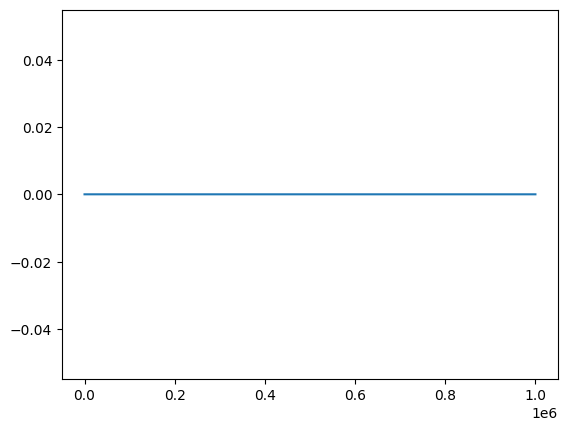

In [19]:
plt.plot(t.success)

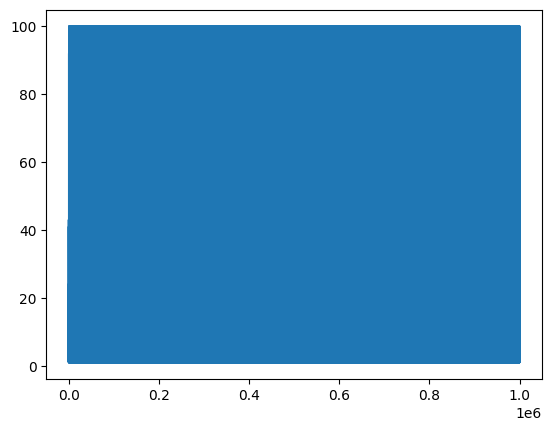

In [14]:
plt.plot(t.jList)